<a href="https://colab.research.google.com/github/dzejkopjarosinski/SP500_ML_Portfolio_Builder/blob/main/Random_Forest_Portfolio_Creator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import datetime
import numpy as np
import yfinance as yf
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn import tree

In [2]:
sp500_index = pd.read_csv('/content/drive/MyDrive/Magisterka/sp500_index.csv')
stock_prices = pd.read_csv('/content/drive/MyDrive/Magisterka/stock_prices.csv')
keystats = pd.read_csv('/content/drive/MyDrive/Magisterka/keystats.csv')
forward_sample = pd.read_csv('/content/drive/MyDrive/Magisterka/forward_sample.csv')

In [3]:
sp500_price = yf.download('''^GSPC''', start="2014-01-01", end="2014-01-03")
sp500_price = sp500_price.drop(columns = ["Open","High","Low","Close","Volume"])
sp500_price.iloc[0]

[*********************100%%**********************]  1 of 1 completed


Adj Close    1831.97998
Name: 2014-01-02 00:00:00, dtype: float64

In [4]:
#Downloading sp500 prices
sp500_prices = yf.download('''^GSPC''', start="2002-01-01", end="2014-01-03")
sp500_prices = sp500_prices.drop(columns = ["Open","High","Low","Close","Volume"])
sp500_prices["date_s"]=sp500_prices.index.strftime("%Y-%m-%d")
sp500_prices

[*********************100%%**********************]  1 of 1 completed


,Adj Close,date_s
Date,,
2002-01-02,1154.670044,2002-01-02
2002-01-03,1165.270020,2002-01-03
2002-01-04,1172.510010,2002-01-04
2002-01-07,1164.890015,2002-01-07
2002-01-08,1160.709961,2002-01-08
...,...,...
2013-12-26,1842.020020,2013-12-26
2013-12-27,1841.400024,2013-12-27
2013-12-30,1841.069946,2013-12-30


Lista wszystkich unikalnych tikckerów

In [5]:
keystats_tickers = list(keystats["Ticker"].unique())
len(keystats_tickers)

471

Data out of sync - repairs needed

In [6]:
latest_data_frame = pd.DataFrame(columns=list(keystats.columns))
ks_ticker_list = keystats["Ticker"].unique()
for ticker in ks_ticker_list:
  latest_data_frame = pd.concat([latest_data_frame,
                                pd.DataFrame.from_records([
                                    keystats[
                                        keystats["Ticker"]==ticker]
                                    .sort_values("Date",ascending=False).iloc[0]])])
latest_data_frame = latest_data_frame.iloc[:,:7]

In [7]:
latest_data_frame["Weekday"]=latest_data_frame["Date"].apply(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d %H:%M:%S").weekday())
latest_data_frame["dt_date"]=latest_data_frame["Date"].apply(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))
latest_data_frame["dt_date"] = latest_data_frame.apply(lambda x: x['dt_date'] + datetime.timedelta(days=1) if x["Weekday"]==6 else x['dt_date'], axis=1)
latest_data_frame["dt_date"] = latest_data_frame.apply(lambda x: x['dt_date'] + datetime.timedelta(days=2) if x["Weekday"]==5 else x['dt_date'], axis=1)
latest_data_frame["Date"] = latest_data_frame["dt_date"].apply(lambda x: datetime.datetime.strftime(x,"%Y-%m-%d %H:%M:%S"))

In [8]:
latest_data_frame["date_s"] = latest_data_frame["Date"].str.split(" ").map(lambda x: x[0])

In [9]:
latest_data_frame.dropna(axis=0, how='any', inplace=True)
latest_data_frame = pd.merge(latest_data_frame,sp500_prices,left_on="date_s",right_on="date_s",how = 'left')
latest_data_frame = latest_data_frame.drop(columns = ["stock_p_change","SP500_p_change","SP500","Date","Unix"])

In [10]:
price_data_for_test = stock_prices[stock_prices["Date"]=='2014-01-02'].T.reset_index().iloc[1:].rename(columns = {"index":"Ticker",2624: "Adj. Close"})
price_data_for_test["Ticker"] = price_data_for_test["Ticker"].apply(str.lower)
price_data_for_test

,Ticker,Adj. Close
1,a,38.633659
2,aa,24.485687
3,aapl,67.984016
4,abbv,44.96273
5,abc,65.594376
...,...,...
475,xrx,28.769037
476,xyl,32.181114
477,yum,48.944916
478,zion,28.571312


In [11]:
testing_data = forward_sample.copy()
testing_data.dropna(axis=0, how='any', inplace=True)
testing_data = testing_data.iloc[:,:7]
test_ticker_list = testing_data["Ticker"].unique()
test_ticker_list = [str.lower(x) for x in test_ticker_list]
len(test_ticker_list)

286

In [12]:
data_for_test_set = price_data_for_test
data_for_test_set["SP500"] = sp500_price.iloc[0,0]
data_for_test_set["Ticker"] = data_for_test_set["Ticker"].apply(str.lower)
data_for_test_set = data_for_test_set[data_for_test_set["Ticker"].isin(test_ticker_list)]

data_for_test_set = pd.merge(data_for_test_set,latest_data_frame,left_on="Ticker",right_on="Ticker",how = "left")

In [13]:
data_for_test_set["SP500_p_change"] = 100*((data_for_test_set["SP500"]/data_for_test_set["Adj Close"])-1)
data_for_test_set["stock_p_change"] = 100*((data_for_test_set['Adj. Close']/data_for_test_set['Price'])-1)

Model

In [14]:
training_data = keystats.set_index('Date')
training_data.dropna(axis=0, how='any', inplace=True)
features = training_data.columns[6:]

X_train = training_data[features].values

OUTPERFORMANCE = 10

y_train = [
  1 if stock_p_change - SP500_p_change >= OUTPERFORMANCE else 0
  for stock_p_change, SP500_p_change in zip(
      training_data["stock_p_change"], training_data["SP500_p_change"]
  )]

In [15]:
y_test = [
  1 if stock_p_change - SP500_p_change >= OUTPERFORMANCE else 0
  for stock_p_change, SP500_p_change in zip(
      data_for_test_set["stock_p_change"], data_for_test_set["SP500_p_change"]
  )]

In [16]:
rfc = RandomForestClassifier(n_estimators = 100, random_state=0, criterion= 'gini')
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [20]:
importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_], axis=0)

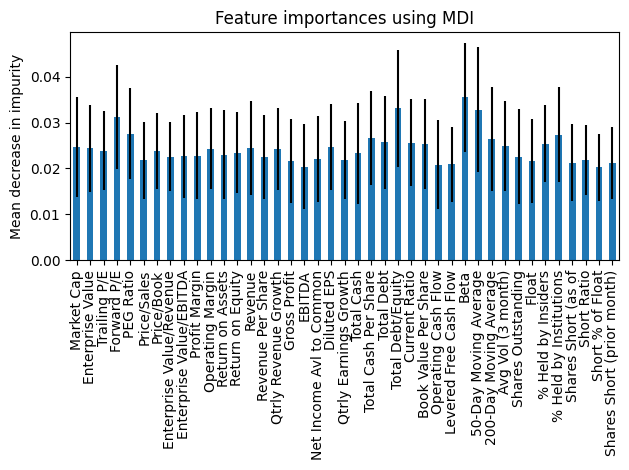

In [21]:
forest_importances = pd.Series(importances, index=features)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [23]:
# Feature List per Ticker
forward_sample = forward_sample.set_index('Date')
forward_sample.dropna(axis=0, how='any', inplace=True)
features = forward_sample.columns[6:]
X_test = forward_sample[features].values

#Lista tickerów
z = forward_sample['Ticker'].values

In [24]:
y_pred = rfc.predict(X_test)

y_pred_b = y_pred.astype(bool)

if sum(y_pred) == 0:
      print("No stocks predicted!")
else:
  invest_list = z[y_pred_b].tolist()
  print(
        f"{len(invest_list)} stocks predicted to outperform the S&P500 by more than {OUTPERFORMANCE}%:"
        )
  print(" ".join(invest_list))

34 stocks predicted to outperform the S&P500 by more than 10%:
ABC LSI TRV IP PH OI BAX FDX INTU SWK WGO DGX LH SNA GT BIIB DHI BWA GES GNW DNR LLL LYB R PBI BLK DLX DIS GTN AMP LMT LM PHM APD


In [39]:
invest_list.append('^GSPC')

In [40]:
len(invest_list)

35

## Accuracy Testing

Aby dokonać backtestingu należy
- Stworzyć indeks z akcji wybranych spółek (Suma Closing Price do jednej kolumny)
- Porównać indeks z indeksem SP500   

In [85]:
data = yf.download(invest_list, start="2002-01-01", end="2022-01-01")
gspc_price = yf.download('^GSPC', start="2002-01-01", end="2022-01-01")

[*********************100%%**********************]  35 of 35 completed

ERROR:yfinance:
3 Failed downloads:
ERROR:yfinance:['LM', 'DNR', 'LLL']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed


In [86]:
closing_prices = data['Adj Close']
gspc_price['^GSPC'] = gspc_price['Adj Close']

In [87]:
GSPC = gspc_price['^GSPC']
index = closing_prices.drop(columns=['^GSPC'], axis=1)
selected_stock_prices = index.copy()
index = index.sum(axis=1)
index = pd.DataFrame(index, columns=['index'])

In [88]:
porownanie = pd.concat([GSPC, index], axis=1)

In [89]:
porownanie.index = pd.to_datetime(porownanie.index, errors='coerce')

In [90]:
mask = (porownanie.index > '2014-01-01')
porownanie = porownanie.loc[mask]

In [91]:
porownanie.head()

,^GSPC,index
Date,,
2014-01-02,1831.979980,2064.933308
2014-01-03,1831.369995,2064.882690
2014-01-06,1826.770020,2053.880322
2014-01-07,1837.880005,2067.481914
2014-01-08,1837.489990,2083.725464


<Axes: xlabel='Date'>

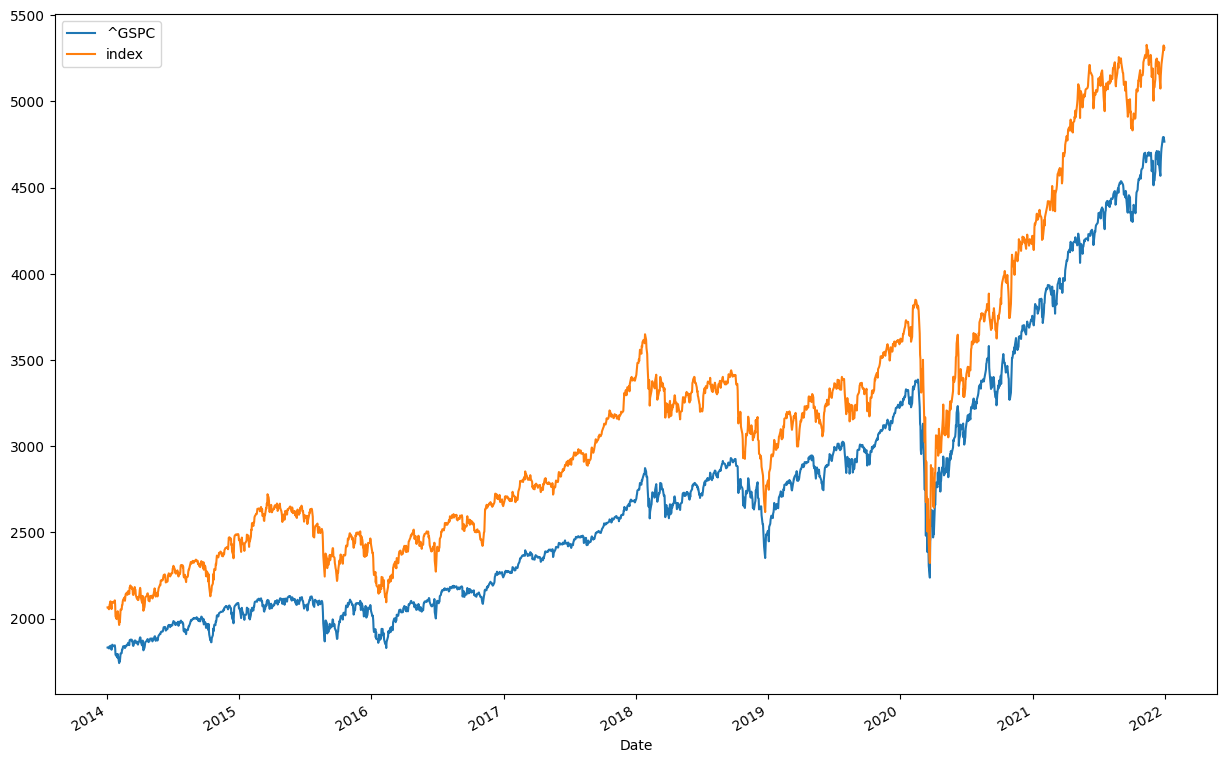

In [92]:
porownanie.plot(figsize=(15,10))

In [93]:
porownanie['procent'] = (porownanie['index'] / porownanie['^GSPC'])-1

In [94]:
porownanie['procent'].mean()

0.16553887835527148

In [95]:
print(porownanie['index'].corr(porownanie['^GSPC']))

0.9902684373998164


In [96]:
porownanie['^GSPC'].std()/porownanie['^GSPC'].mean()

0.27577433592246414

In [97]:
porownanie['index'].std()/porownanie['index'].mean()

0.2644420169570808

In [98]:
last_row = porownanie.iloc[-1]
first_row = porownanie.iloc[0]
result = (last_row - first_row)/first_row

# Print the result
print(result)

^GSPC      1.601655
index      1.572246
procent   -0.100201
dtype: float64
